In [1]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


import numpy as np

from ops import *   # part of the current code, ops.py, 
from utils import * # part of the current code, utils.py
import os 
import time
from glob import glob
#from scipy.misc import imsave as ims  # I had to comment it not to receive error
from random import randint 
from data_providers import * 
slim = tf.contrib.slim #TF-Slim is like KERAS, a library that makes building, training and evaluation neural networks simple. \
import scipy as sp
import pickle
from tensorflow.keras import datasets
import tensorflow.data as td
from tqdm import tqdm_notebook as tqdm # تقدم


config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=.3),
    device_count = {'GPU': 1}
)



'''Keras function to download mnist'''
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data() # Load Data
train_images, test_images = np.float32(train_images / 255.0), np.float32(test_images / 255.0) # 0 to 1 instead of 0 to 255


    

Populating the interactive namespace from numpy and matplotlib


In [2]:
params = {
    'batch_size':64,  
    'image_dim':28*28*1, 
    'imageshape': [64,28,28,1], 
    'c':1,
    'h':28,
    'w':28,
    'epochs':20, 
    'noise_dim':64
}


In [3]:
# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
print('Iterator:', batch_images)


# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')




Dataset Object: <DatasetV1Adapter shapes: (64, 28, 28), types: tf.float32>
Iterator: Tensor("IteratorGetNext:0", shape=(64, 28, 28), dtype=float32)


In [4]:

'''Notice that unlike usual GAN, this is not a binary classifier. The output is a vector of dim 3.'''
def discriminator(z, z_dim=params['noise_dim'], reuse=False, training=True):
    
    with tf.variable_scope("disc") as scope:
        if reuse:
                scope.reuse_variables() 
      
        h0 = z  
        h1 = lrelu(slim.fully_connected(h0, int(z_dim/2))) 
        h1 = slim.dropout(h1, keep_prob=0.5, is_training=training)
        h2 = lrelu(slim.fully_connected(h1, int(z_dim/4))) 
        h2 = slim.dropout(h2, keep_prob=0.5, is_training=training) 
        h3 = slim.fully_connected(h2, 3) ## Farza: A multivariate regressor. Number of outputs is 3. First: P, Second: Q, Last: M  

        return h3  
    
    
def encoder(image, z_dim=params['noise_dim'], batchsize=params['batch_size'], h=params['h'], w=params['w'], c=params['c'], df_dim=16):
    with tf.variable_scope("encoder") as scope:

        h0 = image ### updated: 28x28X1
        h0 = lrelu(conv2d(h0, 1, df_dim, name='d_h0_conv')) #### 14x14x16 shape
        h1 = lrelu(conv2d(h0, df_dim, df_dim*2, name='d_h1_conv')) #### 7 x 7 x 32 = 1568
        h2 = tf.reshape(h1, [batchsize, -1]) ### 1568
        mu = dense(h2, 1568, z_dim, scope='d_h3_lin_mu')   ##### 1568 to noise_dim
        log_sigma_sq = dense(h2, 1568, z_dim, scope='d_h3_lin_sigma') ######## 1568 to noise_dim

        return mu,log_sigma_sq
    


        
def generator(z,z_dim=params['noise_dim'],batchsize=params['batch_size'],h=params['h'],w=params['w'],c=params['c'],gf_dim=16,reuse=False):
    with tf.variable_scope("gen") as scope:
        if reuse:
                scope.reuse_variables()
        z2 = dense(z, z_dim, 1568, scope='g_h0_lin') 

        h0 = tf.nn.relu(tf.contrib.layers.batch_norm(tf.reshape(z2, [-1, 7, 7, gf_dim*2]))) # 7x7x32

        h1 = tf.nn.relu(tf.contrib.layers.batch_norm(conv_transpose(h0, [batchsize, 14, 14, gf_dim], "g_h1"))) #14*14*16

        h2 = tf.nn.sigmoid(conv_transpose(h1, [batchsize, h, w, c], "g_h2"))  ### 
        
        return h2  

In [5]:
tf.reset_default_graph()

# DataLoader and iterator
batch = td.Dataset.from_tensor_slices(train_images).shuffle(len(train_images), reshuffle_each_iteration=True).repeat().batch(params['batch_size'], drop_remainder=True).prefetch(10)
print('Dataset Object:', batch)
iterator = batch.make_initializable_iterator()
batch_images = iterator.get_next()
batch_images = tf.reshape(batch_images, [64,28,28,1])


print('Iterator:' ,batch_images)


# Placeholders for input 
gen_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='input_noise')
m_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='m_input')
n_input = tf.placeholder(tf.float32, shape=[None, params['noise_dim']], name='n_input')


# Build VAE Network
mu,log_sigma_sq = encoder(batch_images)
eps = tf.random_normal((params['batch_size'], params['noise_dim']), 0, 1, dtype=tf.float32)
z = mu+(tf.sqrt(tf.exp(log_sigma_sq))* eps)
gen_sample = generator(z)
print("gen_sample", gen_sample.shape)
# Random Sampler
gen_rv = generator(gen_input,reuse=True)

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(eps)
disc_fake = discriminator(z,reuse=True)
disc_m = discriminator(eps+m_input,reuse=True)
disc_m_gen = discriminator(z+n_input,reuse=True)

# Build Loss



a = np.tile([1.,0.,0.],params['batch_size'])
b = np.tile([0.,1.,0.],params['batch_size'])
c = np.tile([0.,0.,1.],params['batch_size'])
label_a = tf.reshape(a,[params['batch_size'],3])
label_b = tf.reshape(b,[params['batch_size'],3])
label_c = tf.reshape(c,[params['batch_size'],3])

disc_loss_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_real, labels=label_a))
disc_loss_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_fake, labels=label_b))
disc_loss_3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m, labels=label_c))
disc_loss_4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=disc_m_gen, labels=label_c))
dloss = disc_loss_1 + disc_loss_2 + disc_loss_3 + disc_loss_4

r_p_m = (tf.nn.softmax(disc_m_gen)[:,0])/(tf.nn.softmax(disc_m_gen)[:,2])
r_q_m = (tf.nn.softmax(disc_m_gen)[:,1])/(tf.nn.softmax(disc_m_gen)[:,2])

sbd = tf.square(r_p_m - 1) - tf.square(r_q_m - 1) - 2*(r_q_m-1)*(r_p_m-r_q_m)
sbd_loss = tf.reduce_mean(sbd)
kld = -0.5 * tf.reduce_sum(1 + log_sigma_sq - tf.square(mu) - tf.exp(log_sigma_sq), 1)
BCE = -tf.reduce_sum(tf.reshape(batch_images, [params['batch_size'], -1]) * tf.log(1e-10 + tf.reshape(gen_sample, [params['batch_size'], -1]))
                           + (1-tf.reshape(batch_images, [params['batch_size'], -1])) * tf.log(1e-10 + 1 - tf.reshape(gen_sample, [params['batch_size'], -1])),1)
vaeloss = tf.reduce_mean(sbd + BCE)
      
#Build Optimizers
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'encoder' in var.name]
g_vars = [var for var in t_vars if 'gen' in var.name]
d_vars = [var for var in t_vars if 'disc' in var.name]

learningrate_gen = 1e-4
learningrate = 1e-4
beta1 = 0.5
g_optim = tf.train.AdamOptimizer(learningrate_gen, beta1=beta1).minimize(vaeloss, var_list=g_vars+e_vars)
d_optim = tf.train.AdamOptimizer(learningrate,     beta1=beta1).minimize(dloss, var_list=d_vars)

#Initialize
start_time = time.time()
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
sess.run(iterator.initializer)



Dataset Object: <DatasetV1Adapter shapes: (64, 28, 28), types: tf.float32>
Iterator: Tensor("Reshape:0", shape=(64, 28, 28, 1), dtype=float32)
gen_sample (64, 28, 28, 1)


In [6]:
g_vars

[<tf.Variable 'gen/g_h0_lin/Matrix:0' shape=(64, 1568) dtype=float32_ref>,
 <tf.Variable 'gen/g_h0_lin/bias:0' shape=(1568,) dtype=float32_ref>,
 <tf.Variable 'gen/BatchNorm/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'gen/g_h1/w:0' shape=(4, 4, 16, 32) dtype=float32_ref>,
 <tf.Variable 'gen/g_h1/b:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'gen/BatchNorm_1/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'gen/g_h2/w:0' shape=(4, 4, 1, 16) dtype=float32_ref>,
 <tf.Variable 'gen/g_h2/b:0' shape=(1,) dtype=float32_ref>]


Epoch: [ 0] [ 936/ 937] time: 70.1855, dloss: 4.1867, gloss: 246.4427,SBD: 0.0206


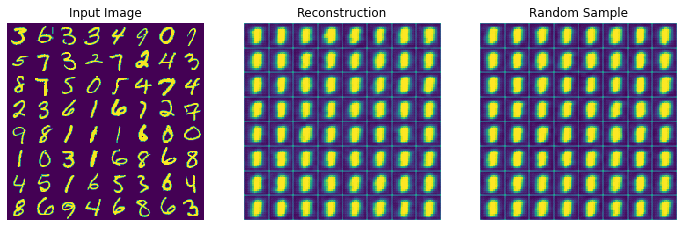


Epoch: [ 1] [ 936/ 937] time: 129.5160, dloss: 3.3725, gloss: 148.5109,SBD: 0.4556


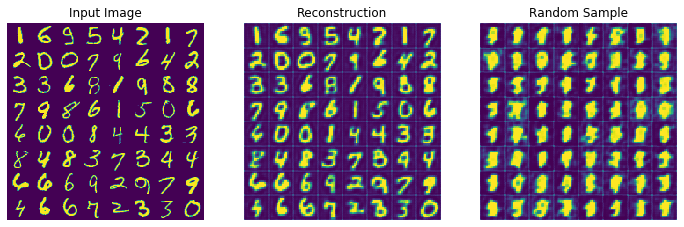


Epoch: [ 2] [ 936/ 937] time: 188.5092, dloss: 3.4825, gloss: 124.6285,SBD: 0.3543


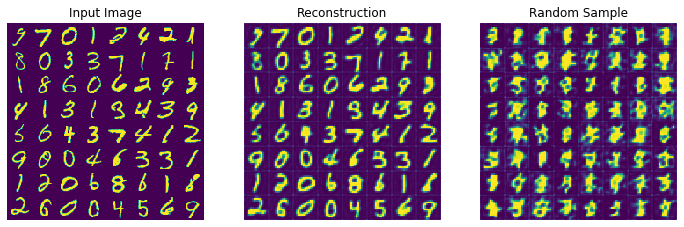


Epoch: [ 3] [ 936/ 937] time: 246.7842, dloss: 3.3029, gloss: 117.9968,SBD: 0.6335


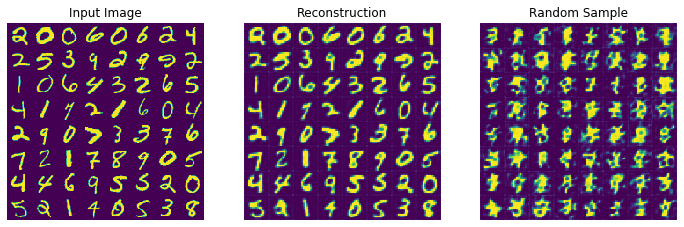


Epoch: [ 4] [ 936/ 937] time: 306.5797, dloss: 3.1996, gloss: 109.8341,SBD: 0.6344


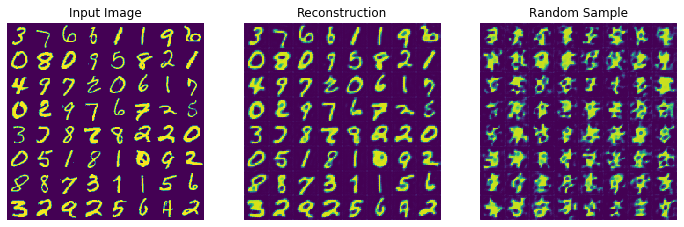


Epoch: [ 5] [ 936/ 937] time: 364.0765, dloss: 3.2980, gloss: 100.9929,SBD: 0.5241


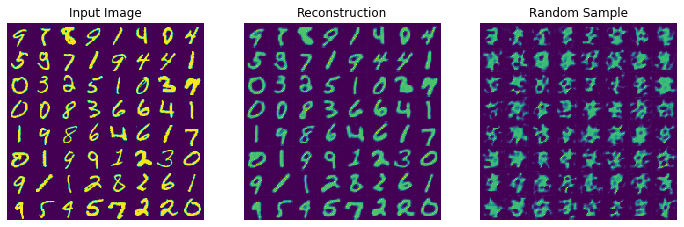


Epoch: [ 6] [ 936/ 937] time: 421.8778, dloss: 3.3822, gloss: 97.3270,SBD: 0.6495


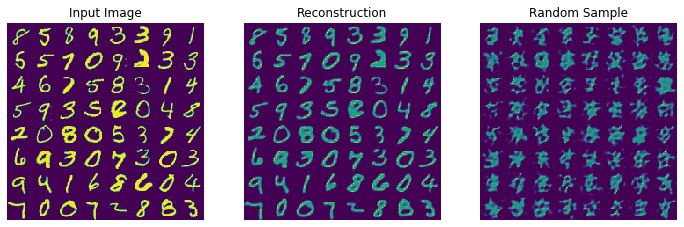


Epoch: [ 7] [ 936/ 937] time: 482.5213, dloss: 3.0413, gloss: 73.1777,SBD: 0.7017


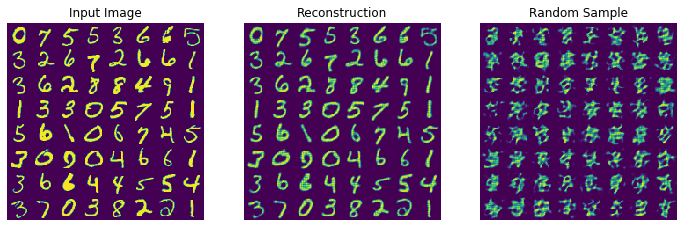


Epoch: [ 8] [ 936/ 937] time: 544.5680, dloss: 2.9882, gloss: 61.4430,SBD: 0.7211


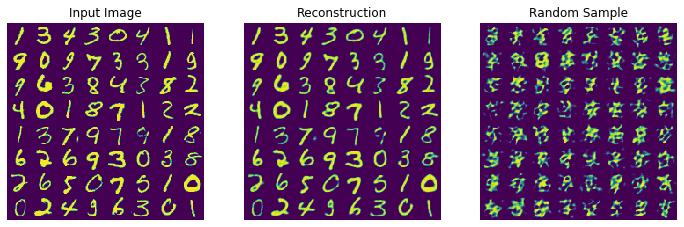


Epoch: [ 9] [ 936/ 937] time: 604.9365, dloss: 3.0240, gloss: 54.7972,SBD: 0.8305


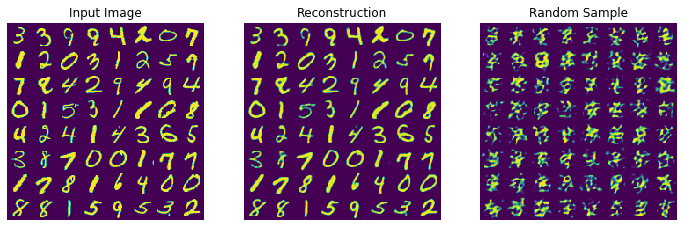


Epoch: [10] [ 936/ 937] time: 662.6960, dloss: 2.9707, gloss: 55.4527,SBD: 0.8581


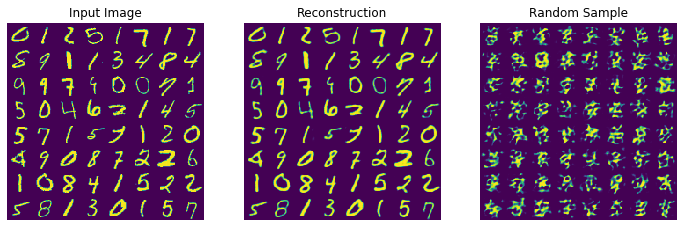


Epoch: [11] [ 936/ 937] time: 720.3155, dloss: 2.9600, gloss: 58.0423,SBD: 0.8176


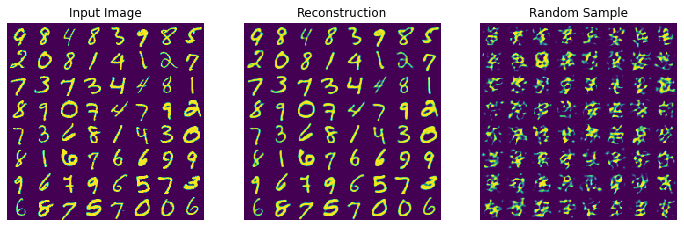


Epoch: [12] [ 936/ 937] time: 778.7023, dloss: 2.9815, gloss: 53.1354,SBD: 0.8209


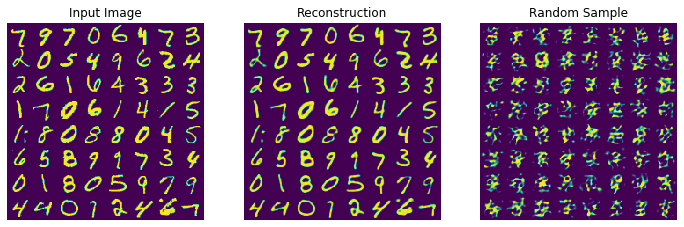


Epoch: [13] [ 936/ 937] time: 836.8228, dloss: 2.9661, gloss: 53.8195,SBD: 0.8535


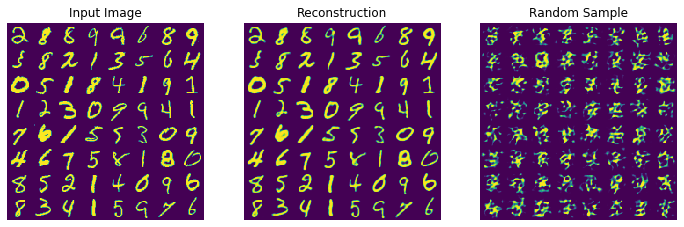


Epoch: [14] [ 936/ 937] time: 896.0334, dloss: 2.9767, gloss: 54.4578,SBD: 0.8223


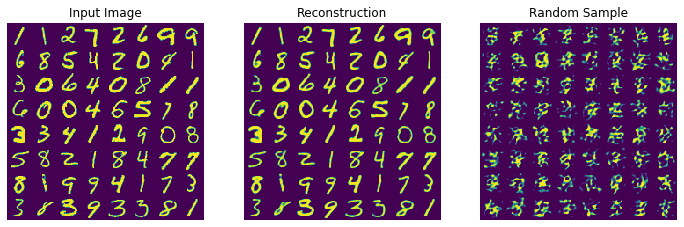


Epoch: [15] [ 936/ 937] time: 955.5352, dloss: 3.0377, gloss: 54.4068,SBD: 0.8521


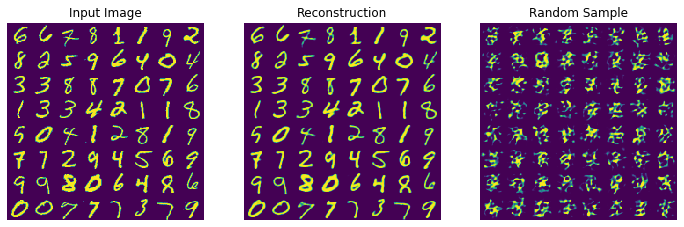


Epoch: [16] [ 936/ 937] time: 1019.9528, dloss: 2.8821, gloss: 51.5049,SBD: 0.8375


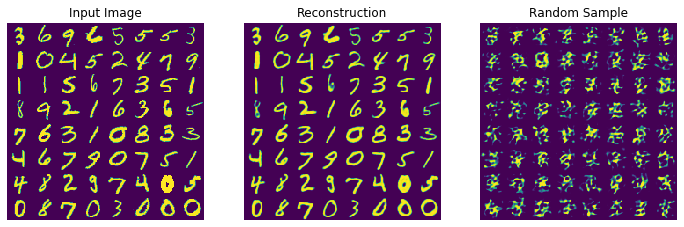


Epoch: [17] [ 936/ 937] time: 1082.8972, dloss: 2.9686, gloss: 54.0179,SBD: 0.8735


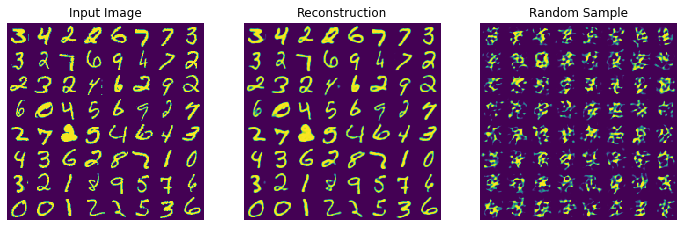


Epoch: [18] [ 936/ 937] time: 1142.4528, dloss: 2.9992, gloss: 55.9170,SBD: 0.8300


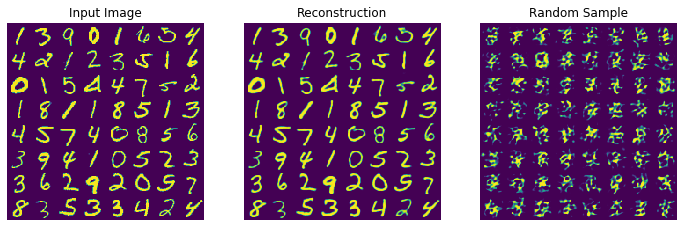


Epoch: [19] [ 936/ 937] time: 1201.3599, dloss: 3.1541, gloss: 52.9819,SBD: 0.8198


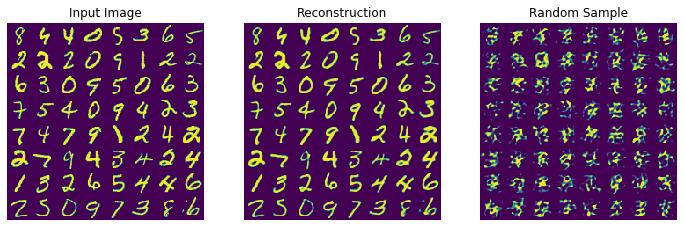

In [7]:
#from ipywidgets import IntProgress
# '------Training VAE and SBD Networks--------------------'
batch_z = np.random.uniform(-1, 1, [params['batch_size'], params['noise_dim']]).astype(np.float32) 
num_batches = int(len(train_images)/params['batch_size'])
dl,gl,sl=0,0,0
for epoch in tqdm(xrange(params['epochs'])):
    for idx in tqdm(range(num_batches)):
        
        m = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])
        n_ = np.random.normal(0, .01, size=[params['batch_size'], params['noise_dim']])

        # Train
        feed_dict = {m_input: m, n_input: n_}
        for _ in range(4):
            sess.run([d_optim],feed_dict=feed_dict)
        _, _, gl, dl, sl = sess.run([d_optim, g_optim, vaeloss, dloss, sbd_loss],
                                feed_dict=feed_dict)
        
        
#     '---------Printing intermediate results-------------'      
    if epoch % 1 == 0:
        
        print("Epoch: [%2d] [%4d/%4d] time: %4.4f, dloss: %4.4f, gloss: %4.4f,SBD: %4.4f" % (epoch, idx, num_batches, time.time() - start_time, dl,gl,sl))
        
        images = sess.run([batch_images,gen_sample,gen_rv],feed_dict = {gen_input: batch_z})
        fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(12,12))
        t = ['Input Image', 'Reconstruction', 'Random Sample']
        for i,image in enumerate(images):
            sdata = np.expand_dims(image,0)
            img = merge(sdata[0],[8,8])
            ax[i].imshow(img)
            ax[i].set_title(t[i])
            ax[i].axis('off')
        plt.show()
    
